## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

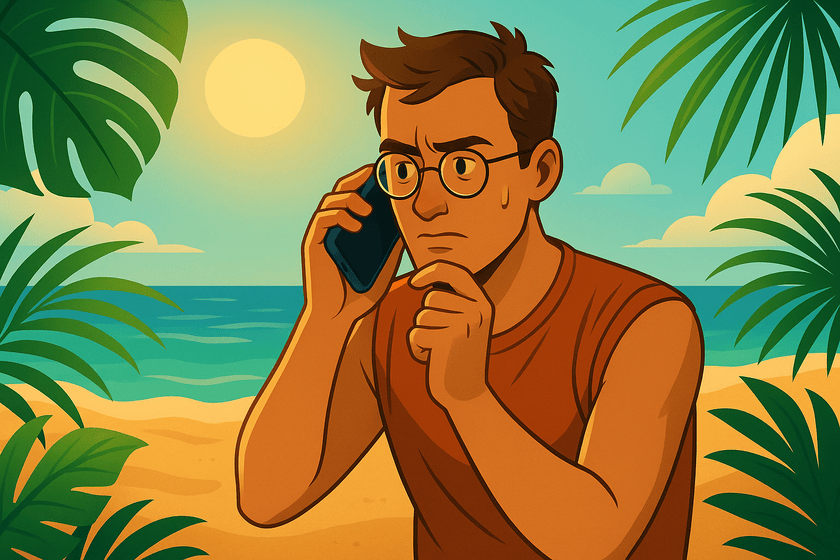

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

In [21]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import itertools
import time
import os
import random
from torch.optim import Adam

In [11]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#**0. Omówienie i przedstawienie danych**
Zbiór MNIST jest zbiorem ręcznie pisanych cyfr (obrazy w skali szarości (0, 255) 28 x 28) z etykietami. Został podzilelony na zbiory treningowy i testowy, liczące odpowiednio 60 000 i 10 000 obrazów.

Połowa rękopisów pochodzi od pracowników amerykańskiego Census Bureau, a druga połowa od uczniów szkół średnich USA. Podział na połowy zachowany jest w podzbiorach testowym i treningowym. MNIST często służy jako benchmark do testowania algorytmów wizji komputerowej i uczenia maszynowego.

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'Shape zbioru testowego: {x_train.shape} \t Shape etykiet zbiortu treningowego: {y_train.shape}')
print(f'Shape zbioru testowego: {x_test.shape} \t Shape etykiet zbiortu treningowego: {y_test.shape}')

Shape zbioru testowego: (60000, 28, 28) 	 Shape etykiet zbiortu treningowego: (60000,)
Shape zbioru testowego: (10000, 28, 28) 	 Shape etykiet zbiortu treningowego: (10000,)


W pytorchu najałtwiej pracować z obiektami klasy data set, by przy ich użyciu tworzyć data loadery, służące do iteracji po kolejnych batchach danych. Dodatkowo ze zbioru testowego wyłączono część służącą do walidacji w czasie uczenia modelu (5 000 obrazów), dane testowe mają być widoczne dla modelu dopiero po zakończeniu procesu uczenia. Ponadto wartości skali szarości zostały znormalizowane, etykiety pozostały cyframi 0-9.

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Liczby próbek: dane treningowe - {len(train_ds)}, dane walidacyjne - {len(val_ds)}, dane testowe - {len(test_ds)} ' )

Liczby próbek: dane treningowe - 55000, dane walidacyjne - 5000, dane testowe - 10000 


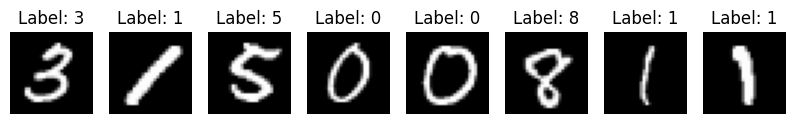

In [15]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

def show_images(images, labels):
  fig, axes = plt.subplots(1, len(images), figsize=(1.25 * len(images), 6))
  for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")

  plt.show()

show_images(images, labels)

#**1. Baseline - zwykła sieć neuronowa**

By w dalszej części pracy przejść do eksperymentowania z sieciami konwolucyjnymi, warto mieć z czym porównać otrzymane rezultaty - sprawdzę jak w zadanianiu klasyfikacji ręcznie pisanych cyfr sprawdzi się zwykła sieć neuronowa.

In [39]:
class SimpleNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Zastosowana sieć składa się z trzech warstw - wejścia, warstwy ukrytej i wyjścia. Pierwsza i ostatnia muszą mieć rozmiar dostosowany do problemu - warstwa wejściowa 784 (784 = 28 * 28), każdy neuron przedstawia wartość jednego z pikseli obrazu. Obraz musi zostać przekształcony do wektora, przez co znacząca część informacji określająca wzajemne położenie pikseli znika - by tego uniknąć stosuje się konwolucje. Warstwa wyjściowa musi mieć 10 neuronów, każdy neuron ma określoną wartość na wyjściu. Jako odpowiedź modelu uznaje się indeks neuronu z najwyższą wartością - wartości na pozostałych neuronach nie są jednak bez znaczenia, bo dzięki nim można obliczać pochodne funkcji kosztu. Zastosowana funkcja aktywacji to ReLU - dla wartości mniejszych równych zero zwraca zero, a dla dodatnich argumentów zwraca ich wartości bez zmian.

In [40]:
model = SimpleNN(784, 64, 10).to(device)

lr = 1e-3

params = {
    'epochs': 8,
    'optimizer': Adam(model.parameters(), lr = lr),
    'criterion': nn.CrossEntropyLoss(),
}

Do treningu użyłem powyższych parametrów. Epochs to liczba epok, czyli przejść po całym zbiorze testowym. W czasie jednej epoki, model otrzymuje na wejście kolejne batche danych, dla których aktualizuje swoje wagi i stałe. Criterion to wybrana funkcja kosztu, a optimizer odpowiada za sposób zmian wag i stałych - zastosowałem Adam, który jest ulepszoną wersją standarodwego SGD. Adam dynamicznie aktuazliuje learning rate osobno dla każdej zmienianej wartości.

In [5]:
def run_epoch(loader, train: bool, params):

    epoch_loss, correct, total = 0.0, 0, 0

    if train:
        model.train()
    else:
        model.eval()

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            #zerowanie gradientów
            params['optimizer'].zero_grad()
        with torch.set_grad_enabled(train):
            #przpeuszczenie danych przez sieć
            logits = model(xb)
            #obliczenie błędu
            loss = params['criterion'](logits, yb)
            if train:
                #obliczenie gradientów
                loss.backward()
                #zmiana parametrów sieci
                params['optimizer'].step()

        #zebranie statystyk
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    return epoch_loss / total, correct / total

def train_model(model, params):

  history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

  start = time.time()

  for epoch in range(1, params['epochs']+1):

    tr_loss, tr_acc = run_epoch(train_loader, train=True, params = params)
    va_loss, va_acc = run_epoch(val_loader, train=False, params = params)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Ep {epoch:02d}/{params['epochs']} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

  print(f"Czas treningu: {time.time()-start:.1f}s")

  return history

Opis pętli uczenia znajduje się w komentarzach. Funkjca train_model zbiera dane z całego procesu uczenia.

In [41]:
history = train_model(model, params)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/8 | train loss 0.3060 acc 0.9111 | val loss 0.2076 acc 0.9374
Ep 02/8 | train loss 0.1483 acc 0.9561 | val loss 0.1406 acc 0.9576
Ep 03/8 | train loss 0.1085 acc 0.9672 | val loss 0.1245 acc 0.9622
Ep 04/8 | train loss 0.0842 acc 0.9733 | val loss 0.1168 acc 0.9646
Ep 05/8 | train loss 0.0701 acc 0.9781 | val loss 0.1024 acc 0.9698
Ep 06/8 | train loss 0.0586 acc 0.9816 | val loss 0.1113 acc 0.9664
Ep 07/8 | train loss 0.0500 acc 0.9838 | val loss 0.1072 acc 0.9696
Ep 08/8 | train loss 0.0432 acc 0.9857 | val loss 0.1146 acc 0.9674
Czas treningu: 128.8s


In [42]:
def show_learning_stats(history):

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  epochs = list(range(1, len(history['train_loss'])+1))

  sns.lineplot(x=epochs, y=history['val_loss'], ax=axes[0], color='green', label='validation')
  sns.lineplot(x=epochs, y=history['train_loss'], ax=axes[0], color='blue', label='training')
  axes[0].set_title('Loss')
  axes[0].grid(True)
  axes[0].legend()

  sns.lineplot(x=epochs, y=history['val_acc'], ax=axes[1], color='green', label='validation')
  sns.lineplot(x=epochs, y=history['train_acc'], ax=axes[1], color='blue', label='training')
  axes[1].set_title('Accuracy')
  axes[1].grid(True)
  axes[1].legend()

  fig.suptitle('Monitorowanie przebiegu uczenia', fontsize=16)
  plt.tight_layout()
  plt.show()

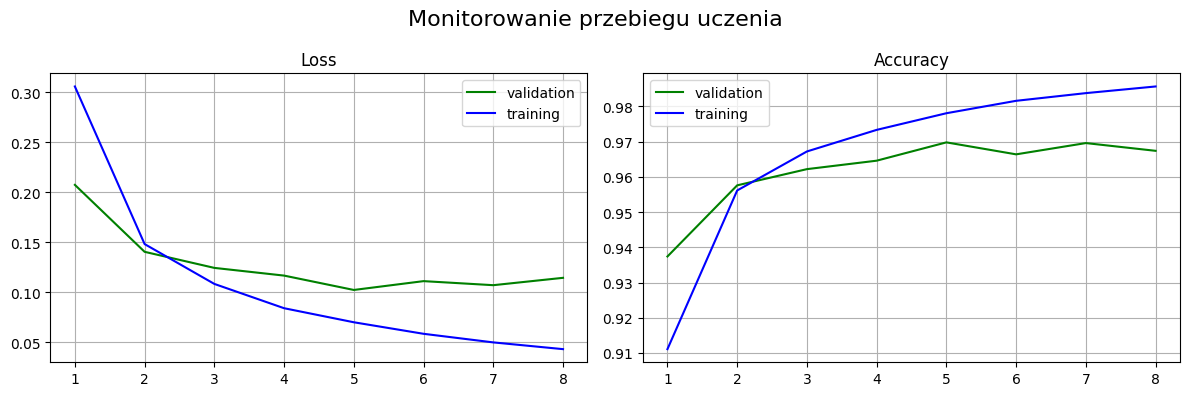

In [43]:
show_learning_stats(history)

In [7]:
def test(model, show = False):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for xb, yb in test_loader:
          xb = xb.to(device, non_blocking=True)
          logits = model(xb)
          preds = logits.argmax(1).cpu().numpy()
          all_preds.append(preds)
          all_targets.append(yb.numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  if show:
    print(classification_report(y_true, y_pred, digits=4))

  accuracy = (y_pred == y_true).mean()

  return accuracy


In [44]:
test(model, show = True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9808    0.9888    0.9848       980
           1     0.9834    0.9894    0.9864      1135
           2     0.9849    0.9467    0.9654      1032
           3     0.9387    0.9861    0.9619      1010
           4     0.9824    0.9644    0.9733       982
           5     0.9859    0.9439    0.9645       892
           6     0.9811    0.9729    0.9769       958
           7     0.9696    0.9621    0.9658      1028
           8     0.9459    0.9692    0.9574       974
           9     0.9496    0.9703    0.9598      1009

    accuracy                         0.9698     10000
   macro avg     0.9702    0.9694    0.9696     10000
weighted avg     0.9702    0.9698    0.9698     10000



np.float64(0.9698)

Najprostsza sieć neuronowa osiągnęła znakomity wynik, accuracy na zbiorze testowym wyniosło lekko poniżej 97%.

#**2. Sieć konwolucyjna**


In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes=10):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1  = nn.Linear(64 * 7 * 7, 128) #64 kanały z mapami 7 x 7 (7 = 28 /2 /2)
        self.fc2  = nn.Linear(128, num_classes)

        self.flatten = nn.Flatten()

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

Pierwsza badana sieć konwolucyjna składa się z dwóch warstw konwolucyjnych - pierwsza składa się z 32 kanałów, a druga z 64. Stosowane filtry są rozmiaru 3 x 3. Każdy filtr to okno zawierające wagi, które są dostosowywane podzas uczenia. Filtr przesuwając się po obrazie tworzy kanał, w którym zapisywane są informacje. W ten sposób sieć konwolucyjna uczy się zwracając uwagę na położenie pikseli, dzięki czemu jest bardziej skuteczna w wizji komputerowej od zwykłej sieci.

Max pooling pozwala zmniejszyć rozmiary obrazu (otrzymanych po konwolucji map) zachowując jedynie najistotniejsze wartości (w powyżyszm kodzie wymiar x i y zmniejsza się dwukrotnie przy każdym zastosowaniu). Dropout wyłącza część neuronów podczas propogacji w sieci, by uczyła się bardziej ogólnych wzroców, a nie polegała na poszczególnych neuronach, których aktywność może wiązać się ze wskazanianiem na jakiś szczegół pojawiający się w danych.

In [ ]:
model = SimpleCNN().to(device)

lr = 1e-3

params = {
    'epochs': 8,
    'optimizer': Adam(model.parameters(), lr = lr),
    'criterion': nn.CrossEntropyLoss(),
}

history = train_model(model, params)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/8 | train loss 0.1751 acc 0.9447 | val loss 0.0605 acc 0.9834
Ep 02/8 | train loss 0.0615 acc 0.9809 | val loss 0.0436 acc 0.9874
Ep 03/8 | train loss 0.0458 acc 0.9857 | val loss 0.0396 acc 0.9866
Ep 04/8 | train loss 0.0375 acc 0.9883 | val loss 0.0343 acc 0.9890
Ep 05/8 | train loss 0.0327 acc 0.9898 | val loss 0.0356 acc 0.9882
Ep 06/8 | train loss 0.0296 acc 0.9905 | val loss 0.0301 acc 0.9918
Ep 07/8 | train loss 0.0249 acc 0.9920 | val loss 0.0296 acc 0.9908
Ep 08/8 | train loss 0.0210 acc 0.9930 | val loss 0.0355 acc 0.9886
Czas treningu: 715.3s


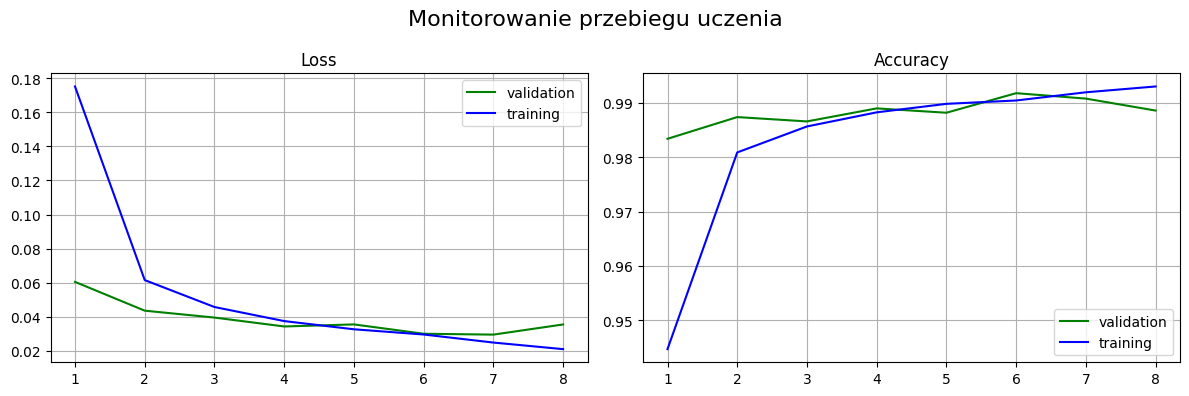

In [ ]:
show_learning_stats(history)

Zbyt duża liczba epok doprowadziła do rozpoczęcia przeuczania się modelu - statystyki na zbiorze testowym stale się poprawiały, podczas gdy wyniki dla zbioru waliacyjnego zaczęły się pogarszać.

In [ ]:
test(model, show = True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9980    0.9959    0.9969       980
           1     0.9974    0.9956    0.9965      1135
           2     0.9904    0.9981    0.9942      1032
           3     0.9950    0.9901    0.9926      1010
           4     0.9969    0.9807    0.9887       982
           5     0.9759    0.9966    0.9861       892
           6     0.9979    0.9896    0.9937       958
           7     0.9951    0.9903    0.9927      1028
           8     0.9898    0.9959    0.9928       974
           9     0.9773    0.9822    0.9797      1009

    accuracy                         0.9915     10000
   macro avg     0.9914    0.9915    0.9914     10000
weighted avg     0.9916    0.9915    0.9915     10000



np.float64(0.9915)

Pomimo podejrzenia rozpoczęcia przeuczania, model osiągnął aż o dwa punkty procentowe większą accuracy od baselinu - aż 99,15 %.

#**3. Różne wersje sieci konwulacyjnej**

* **Zmniejszenie liczby kanałów w warstwach**


In [21]:
class SimpleCNN_halfChannels(nn.Module):

    def __init__(self, num_classes=10):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1  = nn.Linear(32 * 7 * 7, 128) #64 kanały z mapami 7 x 7 (7 = 28 /2 /2)
        self.fc2  = nn.Linear(128, num_classes)

        self.flatten = nn.Flatten()

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [22]:
model = SimpleCNN_halfChannels().to(device)

lr = 1e-3

params = {
    'epochs': 6,
    'optimizer': Adam(model.parameters(), lr = lr),
    'criterion': nn.CrossEntropyLoss(),
}

history = train_model(model, params)

Ep 01/6 | train loss 0.2157 acc 0.9322 | val loss 0.0650 acc 0.9802
Ep 02/6 | train loss 0.0765 acc 0.9764 | val loss 0.0463 acc 0.9860
Ep 03/6 | train loss 0.0581 acc 0.9818 | val loss 0.0437 acc 0.9864
Ep 04/6 | train loss 0.0491 acc 0.9843 | val loss 0.0418 acc 0.9884
Ep 05/6 | train loss 0.0430 acc 0.9865 | val loss 0.0373 acc 0.9888
Ep 06/6 | train loss 0.0380 acc 0.9879 | val loss 0.0350 acc 0.9896
Czas treningu: 250.3s


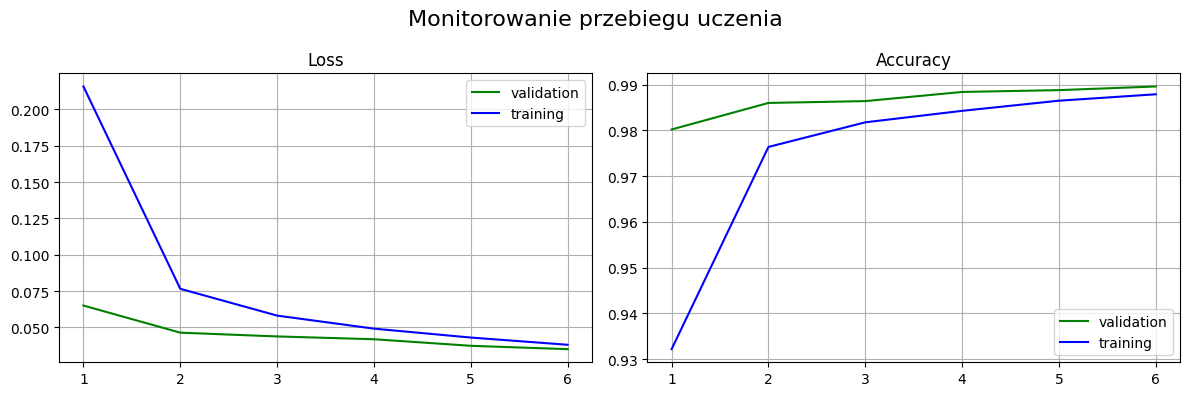

In [23]:
show_learning_stats(history)

In [26]:
test(model, show = True)

              precision    recall  f1-score   support

           0     0.9919    0.9969    0.9944       980
           1     0.9930    0.9982    0.9956      1135
           2     0.9951    0.9913    0.9932      1032
           3     0.9844    0.9980    0.9912      1010
           4     0.9929    0.9949    0.9939       982
           5     0.9888    0.9899    0.9894       892
           6     0.9958    0.9843    0.9900       958
           7     0.9883    0.9903    0.9893      1028
           8     0.9917    0.9774    0.9845       974
           9     0.9891    0.9881    0.9886      1009

    accuracy                         0.9911     10000
   macro avg     0.9911    0.9909    0.9910     10000
weighted avg     0.9911    0.9911    0.9911     10000



np.float64(0.9911)

Sieć konwolucyjna z dwukrotnie mniejszą liczbą kanałów spisała się niemal identycznie, może to wynikać z tego, że by poprawnie sklasyfikować obrazki z MNIST nie trzeba zwracać uwagi aż na tak dużą liczbę zależności.

* **Dodanie trzeciej warstwy konwolucyjnej**

In [34]:
class SimpleCNN_halfChannels_threeLayers(nn.Module):

    def __init__(self, num_classes=10):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1  = nn.Linear(64 * 3 * 3, 128) #64 kanały z mapami 7 x 7 (7 = 28 /2 /2)
        self.fc2  = nn.Linear(128, num_classes)

        self.flatten = nn.Flatten()

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [35]:
model = SimpleCNN_halfChannels_threeLayers().to(device)

lr = 1e-3

params = {
    'epochs': 6,
    'optimizer': Adam(model.parameters(), lr = lr),
    'criterion': nn.CrossEntropyLoss(),
}

history = train_model(model, params)

Ep 01/6 | train loss 0.2546 acc 0.9197 | val loss 0.0826 acc 0.9728
Ep 02/6 | train loss 0.0725 acc 0.9781 | val loss 0.0441 acc 0.9874
Ep 03/6 | train loss 0.0549 acc 0.9829 | val loss 0.0375 acc 0.9898
Ep 04/6 | train loss 0.0458 acc 0.9859 | val loss 0.0390 acc 0.9890
Ep 05/6 | train loss 0.0383 acc 0.9879 | val loss 0.0388 acc 0.9862
Ep 06/6 | train loss 0.0338 acc 0.9894 | val loss 0.0306 acc 0.9910
Czas treningu: 280.1s


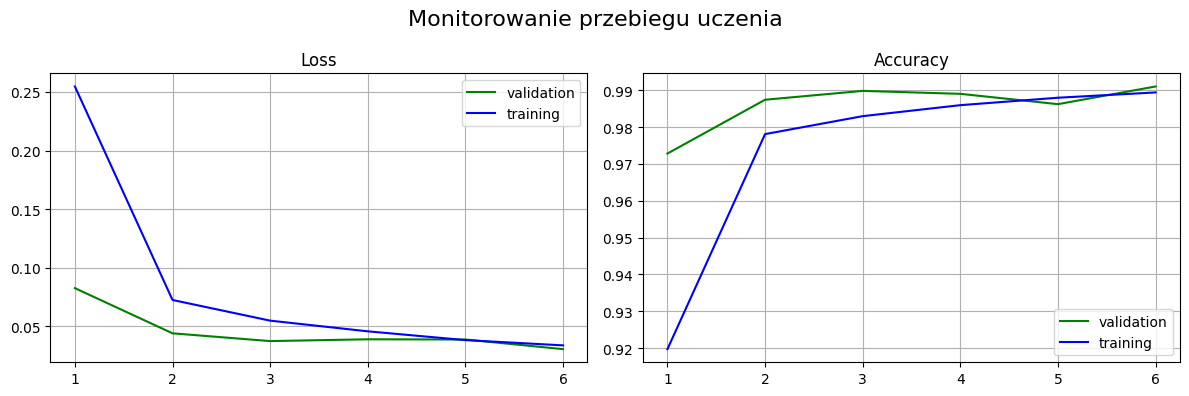

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9959    0.9969    0.9964       980
           1     0.9921    0.9982    0.9952      1135
           2     0.9971    0.9903    0.9937      1032
           3     0.9873    0.9980    0.9926      1010
           4     0.9938    0.9868    0.9903       982
           5     0.9977    0.9854    0.9915       892
           6     0.9958    0.9875    0.9916       958
           7     0.9845    0.9883    0.9864      1028
           8     0.9928    0.9918    0.9923       974
           9     0.9824    0.9931    0.9877      1009

    accuracy                         0.9918     10000
   macro avg     0.9919    0.9916    0.9918     10000
weighted avg     0.9918    0.9918    0.9918     10000



np.float64(0.9918)

In [36]:
show_learning_stats(history)
test(model, show = True)

Ten wariant sieci osiągnął nawjyższe dotychczas accuracy, jednak trzeba pamiętać, że różnice są rzędu ułamków punkta proccentowego, więc w praktyce nie ma to znaczenia

* **Dodanie BatchNorm do pierwszej wersji**

BatchNorm normalizuje aktywacje neuronów w trakcie uczenia

In [45]:
class SimpleCNN_batchNorm(nn.Module):

    def __init__(self, num_classes=10):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1  = nn.Linear(64 * 7 * 7, 128) #64 kanały z mapami 7 x 7 (7 = 28 /2 /2)
        self.bn3  = nn.BatchNorm1d(128)
        self.fc2  = nn.Linear(128, num_classes)

        self.flatten = nn.Flatten()

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        x = self.flatten(x)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [46]:
model = SimpleCNN_batchNorm().to(device)

lr = 1e-3

params = {
    'epochs': 6,
    'optimizer': Adam(model.parameters(), lr = lr),
    'criterion': nn.CrossEntropyLoss(),
}

history = train_model(model, params)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/6 | train loss 0.1463 acc 0.9643 | val loss 0.0485 acc 0.9868
Ep 02/6 | train loss 0.0579 acc 0.9822 | val loss 0.0445 acc 0.9870
Ep 03/6 | train loss 0.0435 acc 0.9863 | val loss 0.0340 acc 0.9894
Ep 04/6 | train loss 0.0376 acc 0.9879 | val loss 0.0309 acc 0.9906
Ep 05/6 | train loss 0.0329 acc 0.9893 | val loss 0.0298 acc 0.9914
Ep 06/6 | train loss 0.0276 acc 0.9913 | val loss 0.0283 acc 0.9908
Czas treningu: 547.1s


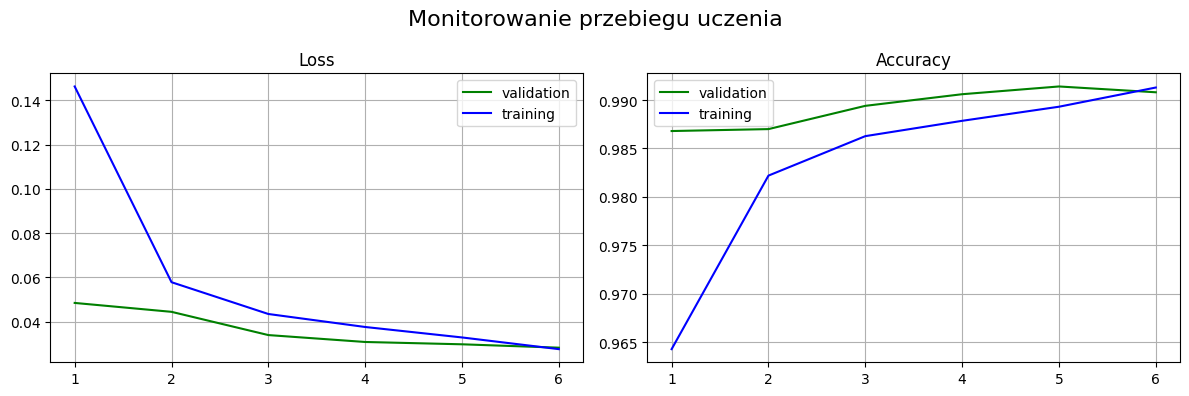

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9908    0.9939    0.9924       980
           1     0.9947    0.9965    0.9956      1135
           2     0.9866    0.9952    0.9908      1032
           3     0.9950    0.9950    0.9950      1010
           4     0.9909    0.9969    0.9939       982
           5     0.9944    0.9933    0.9938       892
           6     0.9968    0.9875    0.9921       958
           7     0.9864    0.9912    0.9888      1028
           8     0.9868    0.9949    0.9908       974
           9     0.9980    0.9752    0.9865      1009

    accuracy                         0.9920     10000
   macro avg     0.9920    0.9920    0.9920     10000
weighted avg     0.9920    0.9920    0.9920     10000



np.float64(0.992)

In [47]:
show_learning_stats(history)
test(model, show = True)

Otrzymane wyniki ponownie są zbliżone do pozostałych - zauważalną różnicą jest wydłużenie się uczenia.

#**4. Ciekawe statystyki**
By zobaczyć, gdzie model popełniał błędy, można wyświetlić przykładowe błędnie sklasyfikowane cyfry.

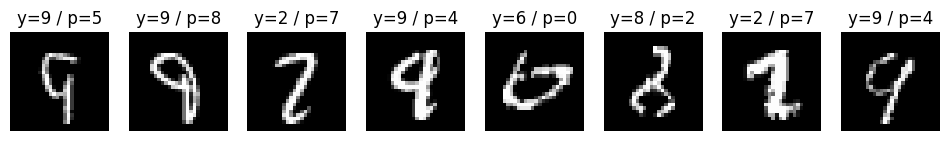

In [17]:
model.eval()
all_preds, all_targets, all_images = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_images.append(xb)
        all_preds.append(preds)
        all_targets.append(yb.numpy())

images = np.concatenate(all_images)
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

wrong_samples = []

for img, yt, ypred in zip(images, y_true, y_pred):
  if(len(wrong_samples) == 8):
     break
  if(yt != ypred):
     wrong_samples.append([img, yt, ypred])

fig, axes = plt.subplots(1, len(wrong_samples), figsize=(12, 2.5))
for ax, (img, y, p) in zip(axes, wrong_samples):
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"y={y.item()} / p={int(p)}")
    ax.axis("off")
plt.show()



plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()



Dodatkowo, warto zobaczyć, z jakimi cyframi ostatni model miał problem, i które błędne wartości im przypisywał.

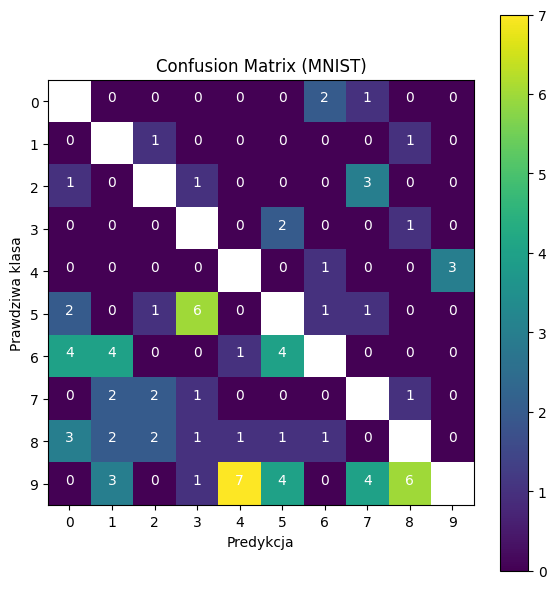

In [38]:
cm = confusion_matrix(y_true, y_pred)
cm_display = cm.astype(float)
np.fill_diagonal(cm_display, np.nan)

plt.figure(figsize=(6,6))
plt.imshow(cm_display, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()

tick_marks = np.arange(cm.shape[0])
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')

plt.tight_layout()
plt.show()

Najbardziej problematyczna wydaje się dziewiątka